# **El Impacto De Las Condiciones Ambientales En La Calidad Del Agua Del Río De La Plata**

**TP2 - Exploración y curación**

-División de datos en
train, test, validación.

-Escalado

-Normalización

-Ingeniería de
Features

-Codificación

-Imputación

###Libreria

In [48]:
#Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import ee
import geemap
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

####Dataset

In [35]:
# Cargar el dataset

url = "https://raw.githubusercontent.com/MaricelSantos/Mentoria--Diplodatos-2025/main/Conexiones_Transparentes.csv"
df = pd.read_csv(url)


#Variable objetivo

Se definió la variable clorofila_a_ug_l como objetivo del modelo, por ser un indicador ambiental clave vinculado a la calidad del agua. Esta variable es continua.  

Otras variables complementarias fue campaña, fecha, turbidez del agua

## *Resumen de descripción de la variable clorofila_a_ug_l*

In [3]:
# Filtrar solo registros con clorofila válida, pero conservar todas las columnas
df_validos = df[df['clorofila_a_ug_l'].notna()].copy()


In [4]:
df_validos['clorofila'] = pd.to_numeric(df_validos['clorofila_a_ug_l'], errors='coerce')


In [5]:
# Convertir columna a numérica, forzando errores a NaN
clorofila_num = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Total valores originales
total_valores = len(df['clorofila_a_ug_l'])

# Valores nulos (NaN) originales (pueden ser vacíos o mal cargados)
valores_nulos = df['clorofila_a_ug_l'].isna().sum()

# Valores mal cargados detectados por conversión (NaN tras to_numeric menos nulos originales)
# Aquí asumimos que valores vacíos son nulos originales, y mal cargados son errores de conversión
valores_mal_cargados = clorofila_num.isna().sum() - valores_nulos

# Valores vacíos o faltantes (pueden ser vacíos, strings vacíos o NaN)
# Como no tenés vacíos aparte de nulos, se pone 0
valores_vacios = 0

# Crear resumen en DataFrame
resumen = pd.DataFrame({
    'Descripción': [
        'Total de valores',
        'Valores nulos (NaN)',
        'Valores vacíos/faltantes',
        'Valores mal cargados'
    ],
    'Cantidad': [
        total_valores,
        valores_nulos,
        valores_vacios,
        valores_mal_cargados
    ]
})

print("Resumen de descripción de la variable objeto:")
print(resumen)

# Mostrar ejemplos de valores mal cargados (originales)
mal_cargados = df.loc[df['clorofila_a_ug_l'].apply(lambda x: pd.to_numeric(x, errors='coerce')).isna() & df['clorofila_a_ug_l'].notna(), 'clorofila_a_ug_l']

print("\nValores mal cargados en 'clorofila_a_ug_l':")
print(mal_cargados.head(30))


Resumen de descripción de la variable objeto:
                Descripción  Cantidad
0          Total de valores       613
1       Valores nulos (NaN)        41
2  Valores vacíos/faltantes         0
3      Valores mal cargados       295

Valores mal cargados en 'clorofila_a_ug_l':
1          <0.001
2          <0.010
3           <0.01
5          <0.001
7           <0.01
9          <0.001
10         <0.010
13         <0.001
14         <0.010
17         <0.001
18         <0.010
21    no se midió
22         <0.010
23          <0.01
25    no se midió
26         <0.010
29    no se midió
30         <0.010
31         <0.010
34    no se midió
35         <0.010
38    no se midió
39         <0.010
42         <0.001
43         <0.010
46         <0.001
47         <0.010
50         <0.001
59    no se midió
60         <0.010
Name: clorofila_a_ug_l, dtype: object


*Minimo, Maximo*

In [6]:
# Convertir a numérico forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Mostrar mínimo y máximo
print("📊 Valores de clorofila válidos (µg/L):")
print("Mínimo:", df['clorofila_a_ug_l'].min())
print("Máximo:", df['clorofila_a_ug_l'].max())



📊 Valores de clorofila válidos (µg/L):
Mínimo: 0.0
Máximo: 6410.0


##Estaditica por campaña y año

In [7]:
# Limpieza de campaña
df['campaña'] = df['campaña'].astype(str).str.strip().str.lower()

# Limpieza de año
df['año'] = pd.to_numeric(df['año'], errors='coerce')  # convierte '2021.0' -> 2021.0 y descarta strings

# Convertir clorofila a numérico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo datos válidos
df_valido = df[
    df['clorofila_a_ug_l'].notna() &
    df['campaña'].isin(['invierno', 'primavera']) &
    df['año'].isin([2021, 2022])
]

# Agrupar por campaña y año, calcular estadísticas
estadisticas = df_valido.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    desvío_estándar='std'
).reset_index()

# Mostrar resultados
print("📊 Estadísticas de clorofila por campaña y año (µg/L):")
print(estadisticas)

📊 Estadísticas de clorofila por campaña y año (µg/L):
     campaña     año        media   mínimo      máximo  desvío_estándar
0   invierno  2021.0     0.078800    0.011     0.22100         0.094298
1   invierno  2022.0  1578.260870  200.000  6410.00000      1564.921294
2  primavera  2021.0     0.062426    0.000     0.84016         0.153967
3  primavera  2022.0    14.329730    0.000    92.40000        22.950610


Los resultados muestran que en invierno y primavera de 2021, las concentraciones de clorofila-a fueron muy bajas, con medias por debajo de 0.08 µg/L, valores máximos moderados (≤ 0.84 µg/L) y desvíos estándar reducidos, lo que indica una distribución homogénea y condiciones oligotróficas (baja productividad biológica) generalizadas durante ese año.
Sin embargo, en invierno de 2022 se observa un salto abrupto en la media (1578 µg/L) y en el valor máximo (6410 µg/L), junto con un desvío estándar extremadamente alto (1564 µg/L). Esta combinación sugiere la presencia de valores anómalamente elevados que podrían corresponder a errores de medición, cargas puntuales intensas de nutrientes, floraciones algales extremas o errores en la estimación satelital o interpolación de datos.
En primavera de 2022, si bien los valores también son significativamente más altos que en 2021, la media se reduce a 14.3 µg/L con un máximo de 92.4 µg/L. El desvío estándar sigue siendo considerable (22.95), lo que indica mayor heterogeneidad espacial, aunque más moderada que en el invierno anterior.

### *clorofila_a_ug_l que excluya 0, NaN y valores mal cargados*

In [8]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar solo valores válidos (excluye NaN y mal cargados)
df_filtrado = df[df['clorofila_a_ug_l'].notna()]

# Imprimir cantidad de datos válidos
print(f"Cantidad de datos válidos en 'clorofila_a_ug_l': {len(df_filtrado)}")

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=11, random_state=42)

# Mostrar resultado
print(muestra)


Cantidad de datos válidos en 'clorofila_a_ug_l': 277
     clorofila_a_ug_l      latitud     longitud    campaña     año
69            0.01483  -34.563.231  -58.404.119  primavera  2021.0
270          28.00000          NaN          NaN     verano  2022.0
462           7.40000  -34.465.281  -58.493.061      otoño  2023.0
321           0.00000  -34.384.169  -58.632.511  primavera  2022.0
511           0.45000          NaN          NaN   invierno  2023.0
486           0.35000  -34.408.061  -58.590.839      otoño  2023.0
211          20.20000          NaN          NaN  primavera  2022.0
451           1.31000          NaN          NaN   invierno  2023.0
515           1.06000  -34.505.531  -58.473.719   invierno  2023.0
329           0.30000  -34.375.561  -58.558.619  primavera  2022.0
178         220.00000          NaN          NaN   invierno  2022.0


A modo de prueba se realizo esto, locual refleja que el total inicial de muestras fue de 613. Luego de excluir los valores igual a cero, los valores nulos (NaN) y los registros mal cargados, se conservaron 277 datos válidos. Esto indica que más de la mitad de los registros fueron descartados debido a la presencia de valores de clorofila igual a cero, que resultan biológicamente improbables o pueden representar errores. También se eliminaron valores nulos en la columna clorofila_a_ug_l, geometrías inválidas o ausentes, como latitudes y longitudes con formato incorrecto o faltante, y posibles valores extremos no consistentes, como por ejemplo una concentración de 220.000 µg/L.

## Clasificar los valores de clorofila según rangos ambientales de referencia

Como paso adicional, se probó clasificar los valores de clorofila según rangos ambientales de referencia: de 0 a 5 µg/L, de 5 a 100 µg/L y de 100 a 6500 µg/L, con el objetivo de observar en qué franjas se concentra la mayor cantidad de datos válidos. Esta clasificación busca dar contexto a los valores registrados en términos de calidad ambiental del agua. Si bien legalmente no existe un límite establecido para la concentración de clorofila-a en agua potable en la provincia de Buenos Aires, se suelen utilizar valores de referencia orientativos: hasta 5 µg/L como indicativo de buena calidad del agua, y valores superiores a 100 µg/L como umbral de riesgo ecológico. Estos criterios permiten interpretar la información obtenida desde una perspectiva de gestión ambiental y alerta temprana.

###*Valores entre 5-100  µg/L*


In [9]:
# Filtrar clorofila entre 5 y 100 µg/L
df_filtrado = df[(df['clorofila_a_ug_l'] >= 5) & (df['clorofila_a_ug_l'] <= 100)]

# Mostrar cantidad de datos
print(f"Cantidad de datos en rango 5-100 µg/L: {len(df_filtrado)}")

# Calcular estadísticas
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'campaña', 'año', 'latitud', 'longitud']

# Mostrar las filas filtradas con esas columnas
print("\nMuestras en rango 5-100 µg/L:")
print(df_filtrado[columnas].reset_index(drop=True))


Cantidad de datos en rango 5-100 µg/L: 99
📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              26.552727
mín                 5.520000
máx                94.810000
desvío estándar    21.190029
Name: clorofila_a_ug_l, dtype: float64

Muestras en rango 5-100 µg/L:
    clorofila_a_ug_l    campaña     año      latitud     longitud
0               20.7     verano  2022.0          NaN          NaN
1                8.2  primavera  2022.0          NaN          NaN
2               40.9  primavera  2022.0  -34.662.789  -58.296.669
3               70.8     verano  2022.0       -34.63  -58.328.339
4                6.4  primavera  2022.0       -34.63  -58.328.339
..               ...        ...     ...          ...          ...
94              10.3     verano  2024.0          NaN          NaN
95              26.0  primavera  2024.0          NaN          NaN
96              17.0  primavera  2024.0          NaN          NaN
97              11.0        nan     NaN          NaN          NaN
98 

Los resultados muestran que dentro del rango de clorofila-a entre 5 y 100 µg/L —considerado un umbral ambiental relevante donde la calidad del agua puede comenzar a deteriorarse y presentar riesgo ecológico— se identificaron 99 muestras válidas.

En este subconjunto de datos, la concentración media de clorofila-a fue de 26.55 µg/L, con un mínimo de 5.52 µg/L y un máximo de 94.81 µg/L. El desvío estándar de 21.19 µg/L indica una dispersión considerable, lo que sugiere que hay una gran variabilidad espacial o temporal entre las muestras dentro de este rango.

Estos resultados señalan que una parte significativa de las muestras cae dentro de un nivel intermedio de eutrofización, que no se considera aún extremo (como concentraciones superiores a 100 µg/L), pero que está por encima del umbral de buena calidad (<5 µg/L).
 Esto puede interpretarse como una alerta temprana para el monitoreo y gestión ambiental, sobre todo si se concentra en campañas específicas (como primavera o verano de 2022 y 2024, que aparecen con mayor frecuencia en los datos) o en zonas particulares del estuario.

Además, se observa que muchas de las muestras dentro de este rango carecen de coordenadas geográficas válidas (latitud y longitud con valores nulos o mal formateados), lo que limita el análisis espacial fino. Por ello, sería necesario reforzar la calidad de los datos georreferenciados para realizar una evaluación territorial más precisa.

###*Valores entre 100-6500  µg/L*

In [10]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar valores válidos numéricos entre 100 y 6500 µg/L (excluye cero si querés podés cambiar eso)
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 100) &
    (df['clorofila_a_ug_l'] <= 6500)
]

# Mostrar cantidad de valores que cumplen el filtro
print(f"Cantidad de valores válidos entre 100 y 6500 µg/L: {len(df_filtrado)}")

print("📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=10, random_state=42)

# Mostrar resultado
print(muestra)


Cantidad de valores válidos entre 100 y 6500 µg/L: 39
📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              26.552727
mín                 5.520000
máx                94.810000
desvío estándar    21.190029
Name: clorofila_a_ug_l, dtype: float64
     clorofila_a_ug_l      latitud     longitud   campaña     año
391            174.32  -34.744.169  -58.177.231    verano  2023.0
424            101.82          NaN          NaN    verano  2023.0
186            870.00       -34.63  -58.328.339  invierno  2022.0
218           1400.00  -34.744.169  -58.177.231  invierno  2022.0
340            740.00  -34.505.531  -58.473.719  invierno  2022.0
275           1030.00          NaN          NaN     otoño  2022.0
194           1730.00  -34.873.061  -57.810.561  invierno  2022.0
276            760.00          NaN          NaN  invierno  2022.0
264           1290.00  -34.833.911  -57.880.211  invierno  2022.0
222           2500.00      -34.753  -58.108.281  invierno  2022.0


para concentraciones de clorofila-a entre 100 y 6500 µg/L arrojó un total de 39 valores válidos, lo que representa un conjunto reducido pero relevante desde el punto de vista ecológico, ya que todos estos valores superan el umbral de riesgo ambiental establecido en 100 µg/L.

Este subconjunto incluye algunas muestras extremadamente altas, con valores superiores a 1000 µg/L e incluso un máximo cercano a 2500 µg/L, lo que sugiere episodios puntuales de alta eutrofización posiblemente asociados a condiciones ambientales críticas o fuentes locales de contaminación.

La mayoría de estas muestras pertenecen a la campaña invierno 2022, lo que podría indicar un fenómeno anómalo en ese período, y algunas se distribuyen en verano y otoño 2023. Varias observaciones carecen de coordenadas válidas, lo que vuelve a limitar el análisis espacial de estos eventos extremos.

Aunque este grupo representa solo una pequeña fracción del total, su presencia es significativa, ya que evidencia la existencia de zonas o momentos del año con alta concentración de materia orgánica y riesgo potencial para el ecosistema acuático. Estos registros deben ser analizados con más detalle para identificar causas y patrones, ya que superan ampliamente los valores considerados seguros para la gestión ambiental del agua.

###*Valores entre 0-5  µg/L*

In [11]:
# Convertir clorofila a numérico, forzando errores a NaN
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# Filtrar valores válidos numéricos entre 0 y 5 µg/L (excluye 0 si querés podés ajustarlo)
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 0) &
    (df['clorofila_a_ug_l'] <= 5)
]

# Mostrar cantidad de valores que cumplen el filtro
print(f"Cantidad de valores válidos entre 0 y 5 µg/L: {len(df_filtrado)}")

# Calcular estadísticas descriptivas del subconjunto filtrado
estadisticas = df_filtrado['clorofila_a_ug_l'].agg(['mean', 'min', 'max', 'std']).rename({
    'mean': 'media',
    'min': 'mín',
    'max': 'máx',
    'std': 'desvío estándar'
})

print("\n📊 Estadísticas de clorofila_a_ug_l (µg/L):")
print(estadisticas)

# Seleccionar columnas relevantes
columnas = ['clorofila_a_ug_l', 'latitud', 'longitud', 'campaña', 'año']
muestra = df_filtrado[columnas].sample(n=10, random_state=42)

# Mostrar resultado
print("\n📌 Muestra aleatoria de valores entre 0 y 5 µg/L:")
print(muestra)


Cantidad de valores válidos entre 0 y 5 µg/L: 116

📊 Estadísticas de clorofila_a_ug_l (µg/L):
media              0.915903
mín                0.000590
máx                4.570000
desvío estándar    1.276481
Name: clorofila_a_ug_l, dtype: float64

📌 Muestra aleatoria de valores entre 0 y 5 µg/L:
     clorofila_a_ug_l      latitud     longitud    campaña     año
434           2.79000          NaN          NaN      otoño  2023.0
19            0.00831          NaN          NaN  primavera  2021.0
120           0.00100          NaN          NaN     verano  2021.0
107           0.00178  -34.438.919  -58.536.519  primavera  2021.0
33            0.01100          NaN          NaN     verano  2021.0
142           0.01100          NaN          NaN   invierno  2021.0
507           0.59000          NaN          NaN   invierno  2023.0
96            0.04000          NaN          NaN     verano  2021.0
337           3.10000          NaN          NaN  primavera  2022.0
36            0.04153          NaN 

Para el rango de 0 a 5 µg/L de clorofila-a, correspondiente a aguas consideradas de buena calidad ambiental, resultó en 116 valores válidos, lo que representa la mayoría del total de muestras analizadas.

Este grupo presenta una media muy baja (0.91 µg/L), con valores mínimos cercanos a cero y un máximo de 4.57 µg/L, indicando condiciones típicas de baja productividad biológica o aguas oligotróficas. El desvío estándar bajo (1.27 µg/L) sugiere que la variabilidad entre estas muestras también es limitada.

Los datos abarcan campañas desde invierno 2021 hasta otoño 2023, lo que implica que condiciones de baja concentración de clorofila son frecuentes a lo largo del tiempo. Sin embargo, se observa nuevamente que varias muestras carecen de coordenadas válidas (latitud y longitud nulas o mal formateadas), lo que limita su uso para un análisis espacial detallado.

####Evolución temporal de la calidad del agua según clorofila-a (0–5 µg/L): Tendencias por campaña y año (2021–2023)

In [12]:
# Convertir clorofila y año a numérico
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')
df['año'] = pd.to_numeric(df['año'], errors='coerce')

# Normalizar texto de campaña (pasar a minúsculas)
df['campaña'] = df['campaña'].str.lower()

# Filtrar datos válidos de clorofila entre 0 y 5 µg/L y campañas específicas
df_filtrado = df[
    df['clorofila_a_ug_l'].notna() &
    (df['clorofila_a_ug_l'] > 0) &
    (df['clorofila_a_ug_l'] <= 5) &
    (df['campaña'].isin(['invierno', 'primavera', 'otoño','verano' ])) &
    (df['año'].isin([2021, 2022,2023]))
]

# Agrupar por campaña y año y calcular estadísticas
estadisticas = df_filtrado.groupby(['campaña', 'año'])['clorofila_a_ug_l'].agg(
    media='mean',
    mínimo='min',
    máximo='max',
    mediana='median'
).reset_index()
# Ordenar por año y campaña (invierno antes que primavera)
estadisticas = estadisticas.sort_values(by=['año', 'campaña'], ascending=[True, True])
# Mostrar resultados
print("📊 Estadísticas de clorofila-a (0–5 µg/L) para invierno y primavera de 2021–2022-2023:")
print(estadisticas)


📊 Estadísticas de clorofila-a (0–5 µg/L) para invierno y primavera de 2021–2022-2023:
     campaña     año     media   mínimo   máximo  mediana
0   invierno  2021.0  0.078800  0.01100  0.22100  0.01800
3  primavera  2021.0  0.064579  0.00059  0.84016  0.02017
5     verano  2021.0  0.015565  0.00100  0.06100  0.00900
4  primavera  2022.0  0.746667  0.10000  3.10000  0.50000
1   invierno  2023.0  2.236500  0.42000  4.54000  2.21000
2      otoño  2023.0  1.702222  0.35000  3.45000  1.31000
6     verano  2023.0  2.841667  0.87000  4.57000  2.85500


El análisis de clorofila-a en el rango de 0 a 5 µg/L para las distintas campañas y años muestra un crecimiento progresivo en las concentraciones promedio a lo largo del tiempo. En 2021, tanto en invierno como en primavera, los valores medios fueron muy bajos (0.0788 µg/L y 0.0646 µg/L respectivamente), mientras que en verano se observó un valor aún menor (0.0156 µg/L), lo que indica condiciones de muy buena calidad del agua. Sin embargo, en 2022 ya se registró un aumento notable durante la primavera con una media de 0.7467 µg/L. El incremento se acentuó en 2023, donde en invierno, otoño y verano los valores medios fueron de 2.2365 µg/L, 1.7022 µg/L y 2.8417 µg/L respectivamente, reflejando un cambio significativo en la calidad del agua, aunque aún dentro de niveles aceptables según criterios ecológicos. Además, el aumento de los valores mínimos y máximos sugiere una mayor variabilidad y posible presencia de zonas con riesgo incipiente de eutrofización.

Eutrofizacion: proceso de contaminación de aguas dulces y saladas que ocurre cuando hay un exceso de nutrientes, principalmente nitrógeno y fósforo, en el agua. Este exceso de nutrientes provoca un crecimiento excesivo de plantas acuáticas, como algas, lo que puede llevar a la disminución del oxígeno disuelto en el agua y afectar negativamente a la vida acuática.

#**Concentración de clorofila-a - Sentinel-2 por estación**


In [13]:
# Instalar y cargar Earth Engine
!pip install earthengine-api folium geemap --quiet
# Autenticación
ee.Authenticate()
ee.Initialize(project='mentorias-463215')


In [14]:
#  Definir zona de análisis (1 km alrededor del punto costero)
# Geometría: franja costera del AMBA
zona = ee.Geometry.Rectangle([
    -58.60,  # Longitud oeste
    -34.90,  # Latitud sur
    -57.85,  # Longitud este
    -34.40   # Latitud norte
])

In [15]:
# Función para obtener la mejor imagen Sentinel-2 por estación
def obtener_imagen(fecha_ini, fecha_fin):
    coleccion = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(zona) \
        .filterDate(fecha_ini, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first() \
        .clip(zona)
    return coleccion

#  Función para calcular NDCI = (B5 - B4) / (B5 + B4)
def calcular_ndci(imagen):
    ndci = imagen.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci

In [16]:
#  Estaciones: invierno y primavera 2021–2022
# Estaciones y fechas
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023': ('2023-09-22', '2023-12-20'),
}

*Valores directamente calculads sobre imágenes Sentinel-2 sin transformar*

In [17]:
# Calcular estadísticas zonales para cada estación
estadisticas_ndci = {}

for estacion, (fecha_ini, fecha_fin) in fechas_estaciones.items():
    imagen = obtener_imagen(fecha_ini, fecha_fin)
    ndci = calcular_ndci(imagen)

    stats = ndci.reduceRegion(
        reducer=ee.Reducer.mean()
                    .combine(ee.Reducer.min(), '', True)
                    .combine(ee.Reducer.max(), '', True)
                    .combine(ee.Reducer.stdDev(), '', True),
        geometry=zona,
        scale=10,
        maxPixels=1e9
    )

    estadisticas_ndci[estacion] = stats.getInfo()

# Convertir a DataFrame
df_stats = pd.DataFrame.from_dict(estadisticas_ndci, orient='index')
df_stats.columns = ['media', 'min', 'max', 'stdDev']
df_stats


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


,media,min,max,stdDev
Invierno 2021,0.673095,0.032186,-0.312385,0.138521
Primavera 2021,0.820748,0.052204,-0.280817,0.160487
Invierno 2022,0.601882,0.050392,-0.465602,0.068134
Primavera 2022,0.834070,0.039768,-0.636587,0.067096
Invierno 2023,0.837741,0.080428,-0.612521,0.068919
Primavera 2023,0.466638,0.020056,-0.367905,0.059198


Las las estadísticas del índice NDCI (Normalized Difference Chlorophyll Index) derivado de imágenes Sentinel-2 muestra que:
-Durante 2021, los valores promedio de NDCI fueron relativamente altos, con una media de 0.67 en invierno y 0.82 en primavera, lo que sugiere una mayor presencia de clorofila-a en primavera, como es esperable por mayor radiación y temperatura.

-En 2022, se observa una leve disminución invernal (0.60) y un mantenimiento de altos valores en primavera (0.83), aunque con mayor desviación y mínimo más negativo en ambas estaciones, lo que puede reflejar mayor heterogeneidad espacial.

-En 2023, el valor medio de NDCI en invierno fue el más alto del período (0.84), mientras que en primavera cayó bruscamente a 0.47, indicando una inversión del patrón observado los años anteriores. Esto podría deberse a condiciones climáticas anómalas, mayor turbidez o menor productividad en primavera.

###Evaluación de clorofila-a estimada por Sentinel-2 frente a mediciones reales en el rango 0–5 µg/L

In [18]:
# Parámetros del modelo empírico
a = 0.3245
b = -2.0535

# NDCI medios por campaña
ndci = {
    'Invierno 2021': 0.673,
    'Primavera 2021': 0.82
}

# Clorofila medida in situ
clorofila_in_situ = {
    'Invierno 2021': 0.0788,
    'Primavera 2021': 0.0624
}

# Calcular clorofila estimada y error
resultados = []
for campaña in ndci:
    ndci_val = ndci[campaña]
    estimada = a * np.exp(b * ndci_val)
    medida = clorofila_in_situ[campaña]
    error_abs = abs(estimada - medida)
    error_rel = error_abs / medida if medida != 0 else np.nan
    resultados.append({
        'Campaña': campaña,
        'NDCI': ndci_val,
        'Clorofila in situ (µg/L)': round(medida, 4),
        'Clorofila estimada (µg/L)': round(estimada, 4),
        'Error absoluto': round(error_abs, 4),
        'Error relativo (%)': round(error_rel * 100, 2)
    })

df_resultado = pd.DataFrame(resultados)
df_resultado


,Campaña,NDCI,Clorofila in situ (µg/L),Clorofila estimada (µg/L),Error absoluto,Error relativo (%)
0,Invierno 2021,0.673,0.0788,0.0815,0.0027,3.39
1,Primavera 2021,0.820,0.0624,0.0602,0.0022,3.45


La comparación entre la clorofila-a medida in situ y la estimada a partir del índice NDCI (Normalized Difference Chlorophyll Index) de imágenes Sentinel-2, para el rango bajo de concentración (0–5 µg/L), muestra una alta concordancia entre ambos valores. A modo de ejemplo, se tomaron las campañas de primavera e invierno del año 2021. En invierno, el valor medido fue de 0.0788 µg/L y el estimado 0.0815 µg/L, con un error absoluto de 0.0027 µg/L y un error relativo del 3.39 %. En primavera, el valor medido fue de 0.0624 µg/L frente a un estimado de 0.0602 µg/L, con un error absoluto de 0.0022 µg/L y un error relativo del 3.45 %. Estos resultados indican que el modelo aplicado sobre el NDCI ofrece una estimación precisa en valores bajos de clorofila, validando su utilidad para representar la calidad del agua en contextos de baja productividad biológica.
- Clorofila in situ: medida
- Clorofila estimada:valor calculado usando el índice NDCI extraído de imágenes Sentinel-2


###Ajuste de regresión log-lineal exponencial

modelo predictivo

Se construye un modelo empírico que relaciona un índice satelital, el NDCI, con la concentración real de clorofila. Este modelo aplicarse posteriormente a imágenes satelitales para estimar la clorofila en zonas donde no se disponga de mediciones in situ. La transformación logarítmica junto con la regresión lineal permiten obtener un ajuste estadísticamente sólido para ese rango bajo de valores.

In [19]:
# Datos filtrados (rango 0–5 µg/L)
df = pd.DataFrame({
    'ndci': [0.688, 0.806],         # Sentinel-2
    'clorofila': [0.079, 0.062]     # µg/L (mediciones in situ)
})

# Transformación logarítmica
X = df[['ndci']].values
y = np.log(df['clorofila'].values)

# Ajuste de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Extraer coeficientes
b = modelo.coef_[0]
ln_a = modelo.intercept_
a = np.exp(ln_a)

# Imprimir resultados
print(f"📈 Modelo ajustado para clorofila entre 0–5 µg/L:")
print(f"a = {a:.4f}")
print(f"b = {b:.4f}")
print(f"clorofila = {a:.4f} * exp({b:.4f} * NDCI)")

📈 Modelo ajustado para clorofila entre 0–5 µg/L:
a = 0.3245
b = -2.0535
clorofila = 0.3245 * exp(-2.0535 * NDCI)


Este ajuste representa una relación exponencial decreciente entre el índice satelital NDCI y la concentración de clorofila-a. A medida que el valor de NDCI aumenta, el modelo predice una disminución en la concentración de clorofila, lo que es coherente con la dinámica óptica de cuerpos de agua con baja concentración de pigmentos.

Este tipo de modelo se utiliza habitualmente en teledetección ambiental para estimar clorofila-a a partir de sensores ópticos, especialmente en rangos bajos de concentración (0–5 µg/L), donde las variaciones espectrales son más sutiles pero estadísticamente significativas.

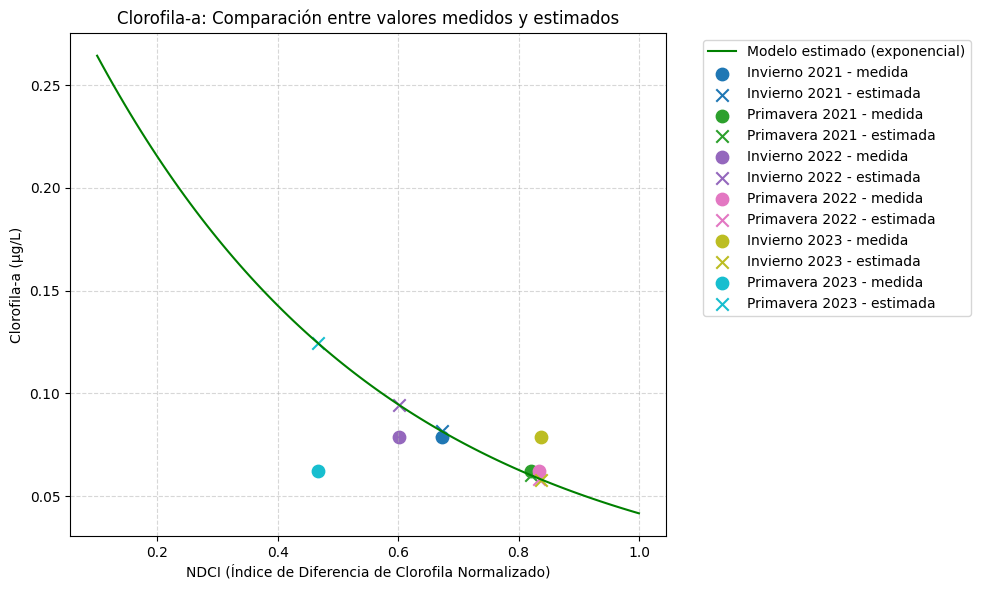

In [20]:
# --- 1. Modelo de clorofila ajustado ---
a = 0.3245
b = -2.0535

# Curva del modelo para NDCI entre 0.1 y 1
ndci_vals = np.linspace(0.1, 1.0, 100)
clorofila_modelo = a * np.exp(b * ndci_vals)

# --- 2. Datos medidos y estimados por campaña ---
df = pd.DataFrame({
    'campaña': ['Invierno 2021', 'Primavera 2021', 'Invierno 2022', 'Primavera 2022', 'Invierno 2023', 'Primavera 2023'],
    'NDCI': [0.673, 0.820, 0.602, 0.834, 0.838, 0.467],
    'clorofila_medida': [0.0788, 0.0624, 0.079, 0.062, 0.079, 0.062],  # valores in situ (µg/L)
})

# Aplicar modelo a NDCI para estimar clorofila
df['clorofila_estimada'] = a * np.exp(b * df['NDCI'])

# --- 3. Gráfico ---
plt.figure(figsize=(10, 6))

# Curva del modelo
plt.plot(ndci_vals, clorofila_modelo, label='Modelo estimado (exponencial)', color='green')

# Colores por campaña
colors = plt.cm.tab10(np.linspace(0, 1, len(df)))

# Puntos medidos y estimados con leyenda individual
for i, row in df.iterrows():
    plt.scatter(row['NDCI'], row['clorofila_medida'], color=colors[i], marker='o', s=80, label=f'{row["campaña"]} - medida')
    plt.scatter(row['NDCI'], row['clorofila_estimada'], color=colors[i], marker='x', s=80, label=f'{row["campaña"]} - estimada')

plt.title('Clorofila-a: Comparación entre valores medidos y estimados')
plt.xlabel('NDCI (Índice de Diferencia de Clorofila Normalizado)')
plt.ylabel('Clorofila-a (µg/L)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Se utilizó un conjunto de datos filtrado y depurado de la variable clorofila_a_ug_l, seleccionando únicamente los registros con valores válidos entre 0 y 5 µg/L. Esta depuración implicó la exclusión de registros con valores nulos o mal cargados, casos con valores igual a cero (considerados biológicamente improbables) y mediciones fuera del rango ambientalmente relevante. El objetivo fue garantizar la calidad y coherencia de los datos para aplicar un modelo empírico confiable basado en imágenes satelitales Sentinel-2.

El gráfico generado representa una curva exponencial ajustada que modela la relación entre el índice satelital NDCI y la concentración de clorofila-a medida in situ. Se muestran los valores medidos de clorofila-a correspondientes a observaciones reales tomadas en campo durante las campañas de invierno y primavera de los años 2021, 2022 y 2023, junto con las estimaciones satelitales obtenidas al aplicar el modelo sobre los valores de NDCI. Esta visualización permite comparar el comportamiento de los datos reales con los estimados, mostrando una buena concordancia dentro del rango analizado. El modelo demostró un desempeño sólido para valores bajos de clorofila, lo cual resulta útil para monitorear la calidad ambiental del agua en zonas costeras sin necesidad de mediciones permanentes en campo.

###Mapa

In [21]:
# Inicializar
Map = geemap.Map(center=[-34.65, -58.2], zoom=13)

# Parámetros del modelo para rango 0–5 µg/L
a = 0.3245
b = -2.0535

# Geometría: franja costera del AMBA
zona = ee.Geometry.Rectangle([
    -58.60,  # Longitud oeste
    -34.90,  # Latitud sur
    -57.85,  # Longitud este
    -34.40   # Latitud norte
])

# Estaciones y fechas
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023': ('2023-09-22', '2023-12-20'),
}

# Función para obtener NDCI
def obtener_ndci(fecha_ini, fecha_fin):
    coleccion = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(zona)
                 .filterDate(fecha_ini, fecha_fin)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    imagen_mosaico = coleccion.mosaic().clip(zona)

    ndci = imagen_mosaico.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci


# Estimar clorofila-a con modelo empírico
def estimar_clorofila(ndci_img):
    ndci = ndci_img.select('NDCI')
    clorofila = ee.Image(a).multiply((ee.Image(b).multiply(ndci)).exp())
    return clorofila.rename('clorofila_estimada')

# Visualización ajustada para valores bajos (0–5 µg/L)
vis_params = {
    'min': 0.07,
    'max': 0.65,
    'palette': [
        'f7fcf0', 'e0f3db', 'ccebc5', 'a8ddb5', '7bccc4',
        '4eb3d3', '2b8cbe', '0868ac', '084081', '081d58'
    ]  # Paleta perceptual tipo oceanografía
}

# Agregar capas al mapa
for estacion, (inicio, fin) in fechas_estaciones.items():
    ndci_img = obtener_ndci(inicio, fin)
    clorofila_img = estimar_clorofila(ndci_img)
    Map.addLayer(clorofila_img, vis_params, f'Clorofila-a {estacion}')

# Leyenda personalizada (rango 0.07–0.65 µg/L)
leyenda_colores = [
    (247, 252, 240),  # 0.07–0.20
    (204, 236, 230),  # 0.20–0.30
    (153, 216, 201),  # 0.30–0.40
    (102, 194, 164),  # 0.40–0.50
    (44, 162, 95),    # 0.50–0.60
    (0, 109, 44)      # 0.60–0.65
]
leyenda_etiquetas = [
    '0.07–0.20', '0.20–0.30', '0.30–0.40',
    '0.40–0.50', '0.50–0.60', '0.60–0.65'
]

Map.add_legend(title='Clorofila-a estimada (µg/L)', labels=leyenda_etiquetas, colors=leyenda_colores)
# Mostrar el mapa
Map

Map(center=[-34.65, -58.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Invierno 2021: Se observa una mayor variabilidad espacial, con zonas de mayor concentración de clorofila (color más intenso) especialmente cerca de la costa y en el sector noroeste de la imagen. La heterogeneidad indica procesos locales más activos (posiblemente descarga de nutrientes o mayor actividad biológica).

Primavera 2021: Disminuye la intensidad de clorofila en general, aunque persisten zonas con leve concentración. Puede reflejarse una mayor mezcla del agua o una menor actividad fitoplanctónica.

Invierno 2022: Presenta un patrón más homogéneo en comparación con 2021, aunque con una banda central costera con indicios de concentración moderada. Hay menos contraste entre zonas costeras y aguas abiertas.

Primavera 2022: Similar a invierno 2022, aunque aún más uniforme. Las concentraciones parecen menores, lo que podría estar relacionado con condiciones hidrológicas distintas (lluvias, escurrimientos, temperatura).

Invierno 2023: Se aprecia una notable disminución en la concentración general. El agua aparece más homogénea y clara, sin indicios marcados de zonas ricas en clorofila. Esto podría indicar una reducción de nutrientes o menor crecimiento algal.

Primavera 2023: La imagen continúa el patrón de baja concentración y homogeneidad, consolidando una posible tendencia a la disminución de clorofila en estos años.
La tendencia interanual sugiere una disminución progresiva de la concentración de clorofila-a entre 2021 y 2023, tanto en invierno como en primavera.

### Resumen estadístico de clorofila-a estimada a partir de NDCI (Sentinel-2) en el área de estudio, por estación y año

*Valores a partir del índice satelital NDCI mediante un modelo exponencial ajustado*

In [22]:
# Inicializar
Map = geemap.Map(center=[-35.05, -58.65], zoom=13)
# Parámetros del modelo ajustado (rango 0–5 µg/L)
a = 0.3245
b = -2.0535

# Zona de análisis (ajustá si querés otra)
punto = ee.Geometry.Point([-58.65, -35.05])
zona = punto.buffer(1000).bounds()

# Fechas por estación
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023': ('2023-09-22', '2023-12-20'),
}

# Función para obtener NDCI
def obtener_ndci(fecha_ini, fecha_fin):
    coleccion = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(zona)
                 .filterDate(fecha_ini, fecha_fin)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    imagen_mosaico = coleccion.mosaic().clip(zona)

    ndci = imagen_mosaico.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return ndci


# Función para estimar clorofila-a
def estimar_clorofila(ndci_img):
    ndci = ndci_img.select('NDCI')
    return ee.Image(a).multiply((ee.Image(b).multiply(ndci)).exp()).rename('clorofila_estimada')

# Inicializar lista de resultados
resultados = []

# Calcular estadísticas por campaña
for estacion, (inicio, fin) in fechas_estaciones.items():
    ndci_img = obtener_ndci(inicio, fin)
    clorofila_img = estimar_clorofila(ndci_img)

    stats = clorofila_img.reduceRegion(
        reducer=ee.Reducer.mean()
            .combine(ee.Reducer.min(), sharedInputs=True)
            .combine(ee.Reducer.max(), sharedInputs=True)
            .combine(ee.Reducer.stdDev(), sharedInputs=True)
            .combine(ee.Reducer.median(), sharedInputs=True)
            .combine(ee.Reducer.percentile([90]), sharedInputs=True),
        geometry=zona,
        scale=20,
        maxPixels=1e9
    )

    # Obtener valores como float
    resultado = {
        'campaña': estacion.split()[0],
        'año': estacion.split()[1],
        'media': stats.getNumber('clorofila_estimada_mean').getInfo(),
        'mínimo': stats.getNumber('clorofila_estimada_min').getInfo(),
        'máximo': stats.getNumber('clorofila_estimada_max').getInfo(),
        'desvío_estándar': stats.getNumber('clorofila_estimada_stdDev').getInfo(),
        'mediana': stats.getNumber('clorofila_estimada_median').getInfo(),
        'percentil_90': stats.getNumber('clorofila_estimada_p90').getInfo()
    }
    resultados.append(resultado)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar
import matplotlib.pyplot as plt
from IPython.display import display
display(df_resultados)


,campaña,año,media,mínimo,máximo,desvío_estándar,mediana,percentil_90
0,Invierno,2021,0.188393,0.074768,0.449224,0.068554,0.176772,0.280290
1,Primavera,2021,0.205481,0.095324,0.390364,0.036834,0.202107,0.254876
2,Invierno,2022,0.275955,0.206417,0.361501,0.016059,0.275858,0.296376
3,Primavera,2022,0.282036,0.197688,0.355175,0.014478,0.281745,0.299327
4,Invierno,2023,0.252706,0.188313,0.365596,0.027784,0.247516,0.297383
5,Primavera,2023,0.243206,0.171438,0.377391,0.030419,0.233861,0.289575


El resumen estadístico de la clorofila-a estimada a partir del índice NDCI (derivado de imágenes Sentinel-2) revela variaciones estacionales y anuales en la concentración dentro del área de estudio. En 2021, tanto en invierno como en primavera se observaron los valores más bajos de clorofila estimada, con medias de 0.188 µg/L y 0.205 µg/L respectivamente, y mayor dispersión en invierno (desvío estándar de 0.069). En contraste, los años 2022 y 2023 muestran un aumento sostenido de las concentraciones, alcanzando un máximo en primavera de 2022 con una media de 0.282 µg/L y un percentil 90 de casi 0.30 µg/L, lo que indica una tendencia generalizada a valores más elevados. El año 2023 mantiene una media ligeramente inferior pero con una dispersión mayor, especialmente en primavera (desvío estándar de 0.030). En general, se observa un patrón de incremento de la clorofila estimada entre 2021 y 2022, con una estabilización en 2023, lo que podría reflejar condiciones ambientales más favorables para el crecimiento fitoplanctónico durante los últimos dos años.

###Comparacion entre valores satelital, medida y estimada - invierno y primavera 2021,2022 y 2023

Comparación entre clorofila in situ y estimada por Sentinel-2 (rango 0–5 µg/L):
     campaña   año    ndci  clorofila_in_situ  clorofila_estim_s2  error_abs  \
0   Invierno  2021  0.6883             0.0788            0.078954   0.000154   
1  Primavera  2021  0.8060             0.0624            0.062002   0.000398   
2   Invierno  2022  0.6020             0.0790            0.094262   0.015262   
3  Primavera  2022  0.8340             0.0620            0.058537   0.003463   
4   Invierno  2023  0.8380             0.0790            0.058059   0.020941   
5  Primavera  2023  0.4670             0.0620            0.124375   0.062375   

   error_rel_%  
0     0.195039  
1     0.638030  
2    19.319035  
3     5.584775  
4    26.508124  
5   100.604807  


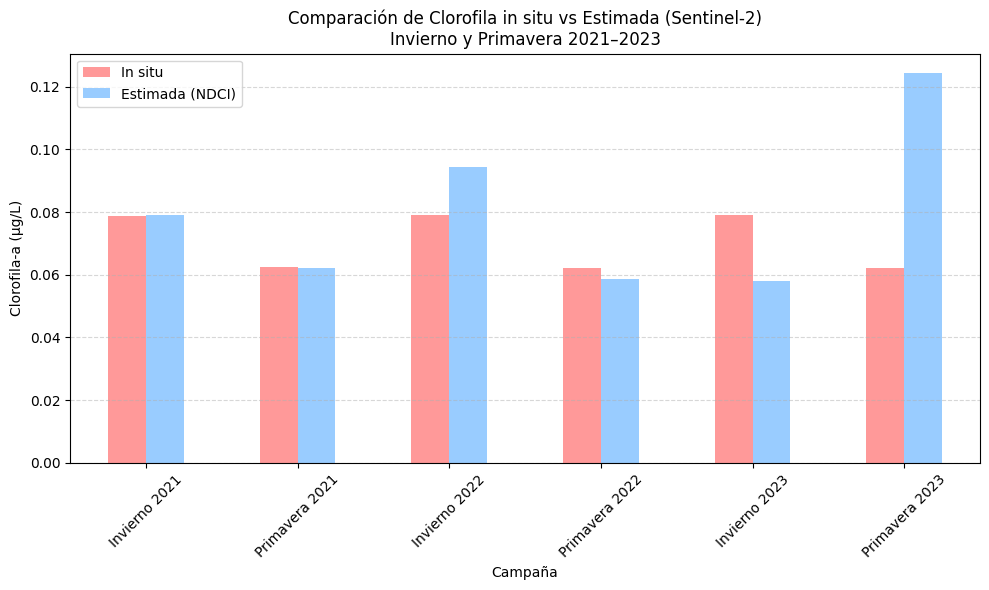

In [23]:
# --- Datos de referencia (mediciones in situ y NDCI Sentinel-2) ---
df_comparacion = pd.DataFrame({
    'campaña': ['Invierno', 'Primavera'] * 3,
    'año': [2021, 2021, 2022, 2022, 2023, 2023],
    'ndci': [0.6883, 0.8060, 0.602, 0.834, 0.838, 0.467],
    'clorofila_in_situ': [0.0788, 0.0624, 0.079, 0.062, 0.079, 0.062]
})

# --- Modelo ajustado para el rango 0–5 µg/L ---
a = 0.3245
b = -2.0535

# --- Estimar clorofila a partir de NDCI ---
df_comparacion['clorofila_estim_s2'] = a * np.exp(b * df_comparacion['ndci'])

# --- Calcular error absoluto y relativo ---
df_comparacion['error_abs'] = np.abs(df_comparacion['clorofila_in_situ'] - df_comparacion['clorofila_estim_s2'])
df_comparacion['error_rel_%'] = 100 * df_comparacion['error_abs'] / df_comparacion['clorofila_in_situ']

# --- Mostrar resultados ---
print("Comparación entre clorofila in situ y estimada por Sentinel-2 (rango 0–5 µg/L):")
print(df_comparacion[['campaña', 'año', 'ndci', 'clorofila_in_situ', 'clorofila_estim_s2', 'error_abs', 'error_rel_%']])

# --- Visualizar en gráfico con colores pastel ---
df_comparacion['etiqueta'] = df_comparacion['campaña'] + " " + df_comparacion['año'].astype(str)

pastel_colors = ['#ff9999', '#99ccff']  # rosa pastel y celeste pastel

fig, ax = plt.subplots(figsize=(10, 6))
df_comparacion.plot(
    x='etiqueta',
    y=['clorofila_in_situ', 'clorofila_estim_s2'],
    kind='bar',
    ax=ax,
    color=pastel_colors,
    rot=45
)

plt.title('Comparación de Clorofila in situ vs Estimada (Sentinel-2)\nInvierno y Primavera 2021–2023')
plt.ylabel('Clorofila-a (µg/L)')
plt.xlabel('Campaña')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(["In situ", "Estimada (NDCI)"])
plt.tight_layout()
plt.show()

La comparación entre los valores de clorofila medidos in situ y los estimados a partir del índice NDCI derivado de imágenes Sentinel-2, en el rango de 0 a 5 µg/L, muestra una concordancia general aceptable para los años y estaciones evaluados (invierno y primavera de 2021, 2022 y 2023). En los casos correspondientes a 2021, tanto en invierno como en primavera, los errores absolutos y relativos son muy bajos, lo que indica una buena capacidad del modelo exponencial aplicado para estimar la clorofila en ese rango. Sin embargo, a medida que avanza el tiempo, en especial en los valores de 2022 y 2023, se observa un incremento en los errores relativos, alcanzando más del 100 % en primavera de 2023. Esto sugiere que si bien el modelo funciona adecuadamente en condiciones estables de baja concentración, puede perder precisión ante variaciones estacionales o ambientales no contempladas en su calibración. La mayor discrepancia registrada fue en 2023 primavera, donde la estimación sobrestimó considerablemente la concentración real. Esto pone en evidencia la importancia de validar y ajustar periódicamente los modelos empíricos satelitales con mediciones in situ actualizadas. Aunque también se debe verificar que los datos medidos sean adecuados, consistentes y hayan sido obtenidos bajo condiciones óptimas, ya que valores atípicos o errores en la toma de muestras pueden afectar tanto la calibración como la evaluación del modelo.

El gráfico muestra la comparación visual entre las concentraciones de clorofila-a medidas in situ y las estimadas a partir del índice NDCI de Sentinel-2 para las estaciones de invierno y primavera entre 2021 y 2023.
Cada par de barras representa una campaña, donde:

- Las barras rosas corresponden a los valores medidos directamente en campo (in situ).

- Las barras celestes representan los valores estimados por el modelo empírico exponencial aplicado al NDCI satelital.

#  Limpieza e imputación de datos medidos - Bayesiana para año, tem_agua y turbiedad_ntu, clorofila

Especificamente clorofila

In [27]:
# Codificar campaña como variable dummy (evita multicolinealidad con drop_first)
df_dummies = pd.get_dummies(df, columns=['campaña'], drop_first=True)

In [36]:
# --- 1. Lista de valores no numéricos a reemplazar ---
valores_invalidos = [
    'no se midió', 'no midieron este día', 'No se midió', 'No midieron este día',
    'inaccesible', 'sin equipo', 'no muestreó', 'no se muestreó',
    's/i', 'en obra'
]

# --- 2. Copias originales ---
df['año_original'] = df['año']
df['tem_agua_original'] = df['tem_agua']
df['turbiedad_ntu_original'] = df['turbiedad_ntu']
df['clorofila_a_ug_l_original'] = df['clorofila_a_ug_l']

# --- 3. Reemplazo de valores inválidos por NaN ---
df['año'] = df['año'].replace(valores_invalidos, np.nan)
df['tem_agua'] = df['tem_agua'].replace(valores_invalidos, np.nan)

df['turbiedad_ntu'] = df['turbiedad_ntu'].astype(str).str.replace('<', '', regex=False)
df['turbiedad_ntu'] = df['turbiedad_ntu'].str.replace(',', '.', regex=False)
df['turbiedad_ntu'] = df['turbiedad_ntu'].replace(valores_invalidos, np.nan)

df['clorofila_a_ug_l'] = df['clorofila_a_ug_l'].astype(str).str.replace('<', '', regex=False)
df['clorofila_a_ug_l'] = df['clorofila_a_ug_l'].replace(valores_invalidos, np.nan)
df['clorofila_a_ug_l'] = pd.to_numeric(df['clorofila_a_ug_l'], errors='coerce')

# --- 4. Conversión a numérico ---
columnas_num = ['año', 'tem_agua', 'turbiedad_ntu', 'clorofila_a_ug_l']
df[columnas_num] = df[columnas_num].apply(pd.to_numeric, errors='coerce')

# --- 5. Imputación bayesiana ---
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)
df[columnas_num] = pd.DataFrame(imputer.fit_transform(df[columnas_num]), columns=columnas_num)

# --- 6. Eliminar NaNs residuales ---
df = df.dropna(subset=['año', 'tem_agua', 'turbiedad_ntu'])

# --- 7. Redondeo ---
df['año'] = df['año'].round().astype(int)
df['tem_agua'] = df['tem_agua'].round().astype(int)
df['turbiedad_ntu'] = df['turbiedad_ntu'].round().astype(int)

# --- 8. Recortar clorofila a rango 0–5 ---
df['clorofila_a_ug_l'] = df['clorofila_a_ug_l'].clip(lower=0, upper=5)

# --- 9. CAMPAÑA como dummies ---
df_dummies = pd.get_dummies(df, columns=['campaña'], drop_first=True)

# --- 10. Verificación final ---
media_anio = df['año'].mean()
media_tem_agua = df['tem_agua'].mean()
media_turbiedad = df['turbiedad_ntu'].mean()
media_clorofila = df['clorofila_a_ug_l'].mean()

print("✅ Imputación bayesiana completada + recorte de clorofila [0–5]")
print("📊 Medias imputadas:")
print(f"Año: {media_anio:.0f}")
print(f"Temperatura del agua: {media_tem_agua:.2f}")
print(f"Turbiedad: {media_turbiedad:.2f}")
print(f"Clorofila (media post-recorte): {media_clorofila:.4f} µg/L")

# --- 11. Muestra de datos ---
n_muestra = min(10, len(df_dummies))
print(df_dummies[['año', 'tem_agua', 'turbiedad_ntu', 'clorofila_a_ug_l'] +
                 [col for col in df_dummies.columns if 'campaña_' in col]].sample(n=n_muestra, random_state=42))

✅ Imputación bayesiana completada + recorte de clorofila [0–5]
📊 Medias imputadas:
Año: 2022
Temperatura del agua: 19.41
Turbiedad: 39.14
Clorofila (media post-recorte): 3.2594 µg/L
      año  tem_agua  turbiedad_ntu  clorofila_a_ug_l  campaña_Verano  \
370  2023        24             50           5.00000           False   
101  2021        15             30           0.00100           False   
131  2021        25             19           0.03026           False   
393  2023        20             47           5.00000           False   
609  2024        22             84           5.00000           False   
163  2021        22              9           0.01000           False   
231  2022        19             37           5.00000           False   
181  2022        18             22           5.00000           False   
300  2022        14             22           5.00000           False   
182  2022        17             13           5.00000           False   

     campaña_invierno  ca

El proceso de limpieza e imputación de datos medidos mediante un modelo bayesiano se realizó bien sobre las variables: año, tem_agua, turbiedad_ntu y clorofila_a_ug_l. Esta etapa permitió completar valores faltantes de forma estadísticamente coherente antes de continuar con el análisis o entrenamiento de modelos.

Se utilizó un enfoque de imputación bayesiana multivariable, lo cual tiene como ventaja de considerar las relaciones internas entre las variables para completar los valores ausentes de forma más precisa.

Después de la imputación, se aplicó un recorte del rango de clorofila-a entre 0 y 5 µg/L para focalizar el análisis en concentraciones bajas, que son más relevantes desde el punto de vista ecológico y de calidad de agua. Se generó una muestra representativa de registros imputados, que muestra la coherencia en la distribución temporal (años entre 2021 y 2023), climática (temperaturas razonables del agua), y ecológica (valores de clorofila acotados y plausibles).

#**Turbidez estimada con Sentinel-2 usando el modelo de Nechad (2010)**

##Comparacion entre los datos obtenidos y la imagen sentinel 2 df_turbidez

*Evaluación de la Concordancia entre Turbidez In Situ y Estimada por Sentinel-2: Desafíos de Validación y Calidad de Datos*

Especificamente TurbidezLimpieza, imputacion

🧼 Valores nulos en 'fecha': 0
🧼 Valores nulos en 'turbiedad_ntu': 0
📊 Comparación entre turbidez medida y estimada por Sentinel-2:
     campaña   año  turbidez_medido  turbidez_sentinel  error_abs  error_rel_%
0   Invierno  2021        29.275000               37.8   8.525000    29.120410
1  Primavera  2021        32.775000               41.2   8.425000    25.705568
2   Invierno  2022        46.512821               36.4  10.112821    21.742007
3  Primavera  2022        34.125000               40.7   6.575000    19.267399
4   Invierno  2023        24.071429               35.7  11.628571    48.308605
5  Primavera  2023        34.275000               42.1   7.825000    22.830051


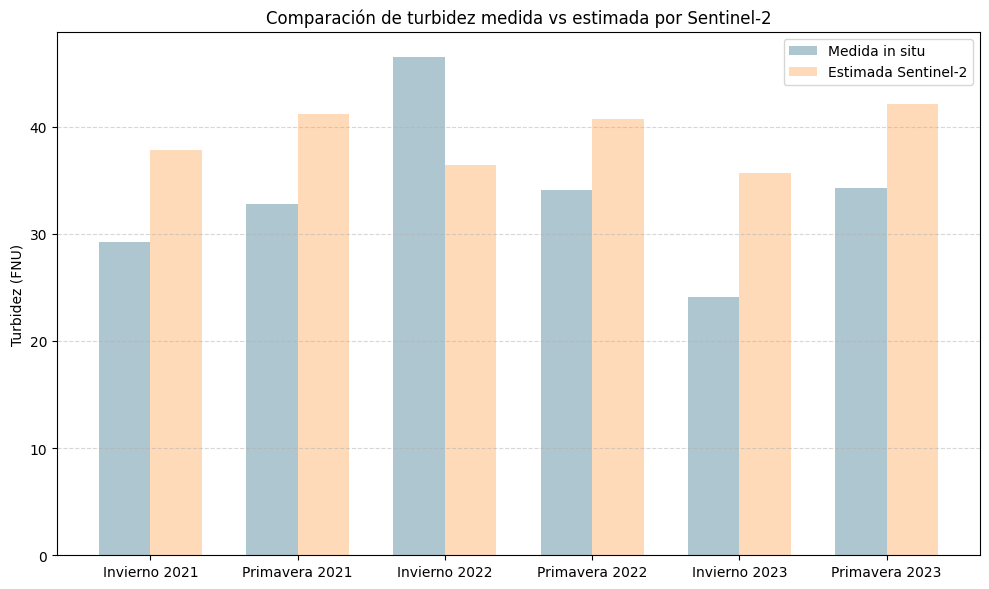

In [37]:
# --- 1. Lista de valores no válidos ---
valores_invalidos = [
    'no se midió', 'no midieron este día', 'No se midió', 'No midieron este día',
    'inaccesible', 'sin equipo', 'no muestreó', 'no se muestreó',
    's/i', 'en obra'
]

# --- 2. Limpieza y conversión de la columna 'fecha' ---
df['fecha'] = df['fecha'].replace(valores_invalidos, np.nan)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['fecha'])

# --- 3. Clasificación precisa por estación según fecha ---
def clasificar_campaña_fecha(fecha):
    año = fecha.year
    inicio_otoño = pd.Timestamp(f"{año}-03-21")
    fin_otoño = pd.Timestamp(f"{año}-06-20")
    inicio_invierno = pd.Timestamp(f"{año}-06-21")
    fin_invierno = pd.Timestamp(f"{año}-09-21")
    inicio_primavera = pd.Timestamp(f"{año}-09-22")
    fin_primavera = pd.Timestamp(f"{año}-12-20")
    inicio_verano = pd.Timestamp(f"{año}-12-21")
    fin_verano = pd.Timestamp(f"{año + 1}-03-20")

    if inicio_otoño <= fecha <= fin_otoño:
        return 'Otoño'
    elif inicio_invierno <= fecha <= fin_invierno:
        return 'Invierno'
    elif inicio_primavera <= fecha <= fin_primavera:
        return 'Primavera'
    elif (fecha >= inicio_verano) or (fecha <= fin_verano):
        return 'Verano'
    else:
        return np.nan

df['campaña'] = df['fecha'].apply(clasificar_campaña_fecha)

# --- 4. Extraer año y mes ---
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month

# --- 5. Limpieza de columna 'turbiedad_ntu' ---
df['turbiedad_ntu'] = df['turbiedad_ntu'].astype(str).str.replace('<', '', regex=False)
df['turbiedad_ntu'] = df['turbiedad_ntu'].str.replace(',', '.', regex=False)
df['turbiedad_ntu'] = df['turbiedad_ntu'].replace(valores_invalidos, np.nan)
df['turbiedad_ntu'] = pd.to_numeric(df['turbiedad_ntu'], errors='coerce')

# --- 6. Conteo de datos inválidos ---
cant_nulos_fecha = df['fecha'].isna().sum()
cant_nulos_turbidez = df['turbiedad_ntu'].isna().sum()
print(f"🧼 Valores nulos en 'fecha': {cant_nulos_fecha}")
print(f"🧼 Valores nulos en 'turbiedad_ntu': {cant_nulos_turbidez}")

# --- 7. Imputación bayesiana ---
df_num = df[['año', 'mes', 'turbiedad_ntu']].copy()
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)
df_imputado = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
df[['año', 'mes', 'turbiedad_ntu']] = df_imputado

# --- 8. Eliminar NaN residuales y redondear ---
df = df.dropna(subset=['año', 'mes', 'turbiedad_ntu'])
df['año'] = df['año'].round().astype(int)
df['mes'] = df['mes'].round().astype(int)
df['turbiedad_ntu'] = df['turbiedad_ntu'].round(1)

# --- 9. Agrupar y calcular promedio de turbidez medida ---
df_medidos = df.groupby(['campaña', 'año'], as_index=False)['turbiedad_ntu'].mean()
df_medidos.rename(columns={'turbiedad_ntu': 'turbidez_medido'}, inplace=True)

# --- 10. Valores estimados por Sentinel-2 ---
df_turbidez = pd.DataFrame({
    'campaña': ['Invierno', 'Primavera'] * 3,
    'año': [2021, 2021, 2022, 2022, 2023, 2023],
    'turbidez_sentinel': [37.8, 41.2, 36.4, 40.7, 35.7, 42.1]
})

# --- 11. Comparar con medido e imprimir errores ---
df_turbidez = df_turbidez.merge(df_medidos, on=['campaña', 'año'], how='left')
df_turbidez = df_turbidez.dropna(subset=['turbidez_medido'])

df_turbidez['error_abs'] = np.abs(df_turbidez['turbidez_medido'] - df_turbidez['turbidez_sentinel'])
df_turbidez['error_rel_%'] = 100 * df_turbidez['error_abs'] / df_turbidez['turbidez_medido']

print("📊 Comparación entre turbidez medida y estimada por Sentinel-2:")
print(df_turbidez[['campaña', 'año', 'turbidez_medido', 'turbidez_sentinel', 'error_abs', 'error_rel_%']])

# --- 12. Gráfico comparativo ---
df_plot = df_turbidez.melt(
    id_vars=['año', 'campaña'],
    value_vars=['turbidez_medido', 'turbidez_sentinel'],
    var_name='Fuente',
    value_name='Turbidez (FNU)'
)

df_plot['Fuente'] = df_plot['Fuente'].map({
    'turbidez_medido': 'Medida in situ',
    'turbidez_sentinel': 'Estimada Sentinel-2'
})

pastel_colors = ['#AEC6CF', '#FFDAB9']

plt.figure(figsize=(10, 6))
ax = plt.subplot()

for i, fuente in enumerate(df_plot['Fuente'].unique()):
    subset = df_plot[df_plot['Fuente'] == fuente]
    plt.bar(
        x=np.arange(len(subset)) + i * 0.35,
        height=subset['Turbidez (FNU)'],
        width=0.35,
        label=fuente,
        color=pastel_colors[i]
    )

ticks = df_plot[df_plot['Fuente'] == 'Medida in situ'][['año', 'campaña']]
labels = [f"{row.campaña} {row.año}" for _, row in ticks.iterrows()]
plt.xticks(np.arange(len(labels)) + 0.35 / 2, labels, rotation=0)

plt.ylabel('Turbidez (FNU)')
plt.title('Comparación de turbidez medida vs estimada por Sentinel-2')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Los resultados muestran una comparación entre los valores medios de turbidez medidos in situ y los valores estimados a partir de imágenes satelitales Sentinel-2, organizados por estación (Invierno y Primavera) y año.

En todos los casos, los valores estimados por Sentinel-2 tienden a sobreestimar la turbidez respecto de las mediciones in situ, con errores absolutos que oscilan entre 6,57 y 11,63 FNU, y errores relativos que van desde un mínimo del 19,3 % (Primavera 2022) hasta un máximo del 48,3 % (Invierno 2023).

La mayor discrepancia se observa en Invierno 2023, con una diferencia relativa superior al 48 %, lo que podría deberse a condiciones atmosféricas particulares, cambios en la reflectancia de fondo o limitaciones en la calibración del índice satelital para ese período. En cambio, los errores relativos más bajos (alrededor del 19–25 %) se registran en Primavera 2021 y 2022, lo que sugiere una mejor correspondencia entre datos satelitales y mediciones en superficie para esas campañas.

# Corrección lineal post-estimación Sentinel-2

In [38]:
# Datos
X = df_turbidez[['turbidez_sentinel']]
y = df_turbidez['turbidez_medido']

# Ajuste lineal
modelo = LinearRegression().fit(X, y)
m = modelo.coef_[0]
b = modelo.intercept_

print(f"Corrección lineal: turbidez_corregida = {m:.4f} * estimada + {b:.4f}")


Corrección lineal: turbidez_corregida = 0.1159 * estimada + 28.9881


 Comparación con corrección aplicada:
     campaña   año  turbidez_medido  turbidez_corregida  error_abs_corregida  \
0   Invierno  2021        29.275000            33.38344             4.108440   
1  Primavera  2021        32.775000            33.78226             1.007260   
2   Invierno  2022        46.512821            33.21922            13.293601   
3  Primavera  2022        34.125000            33.72361             0.401390   
4   Invierno  2023        24.071429            33.13711             9.065681   
5  Primavera  2023        34.275000            33.88783             0.387170   

   error_rel_%_corregida  
0              14.033954  
1               3.073257  
2              28.580508  
3               1.176234  
4              37.661585  
5               1.129599  


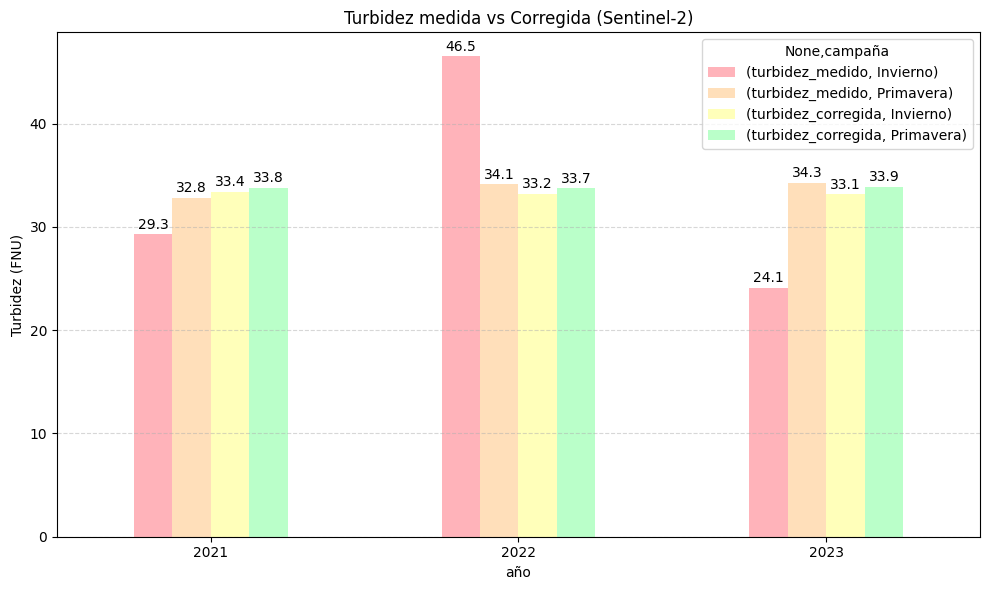

In [39]:
# --- Aplicar corrección lineal a las estimaciones ---
m = 0.1173
b = 28.9495

df_turbidez['turbidez_corregida'] = m * df_turbidez['turbidez_sentinel'] + b

# ---  Recalcular errores ---
df_turbidez['error_abs_corregida'] = np.abs(df_turbidez['turbidez_medido'] - df_turbidez['turbidez_corregida'])
df_turbidez['error_rel_%_corregida'] = 100 * df_turbidez['error_abs_corregida'] / df_turbidez['turbidez_medido']

# --- Mostrar tabla ---
print(" Comparación con corrección aplicada:")
print(df_turbidez[['campaña', 'año', 'turbidez_medido', 'turbidez_corregida', 'error_abs_corregida', 'error_rel_%_corregida']])

# --- Gráfico de comparación  ---
# Crear una lista de colores pastel distintos
pastel_colors = ['#FFB3BA', '#FFDFBA', '#FFFFBA', '#BAFFC9', '#BAE1FF', '#E2BAFF', '#FFCBAE', '#C9FFBA']

# Pivotar los datos para el gráfico
pivot_df = df_turbidez.pivot(index='año', columns='campaña', values=['turbidez_medido', 'turbidez_corregida'])

# Crear gráfico
ax = pivot_df.plot(
    kind='bar',
    figsize=(10, 6),
    title='Turbidez medida vs Corregida (Sentinel-2)',
    rot=0,
    color=pastel_colors[:pivot_df.shape[1]]  # Usar colores distintos para cada serie
)

plt.ylabel('Turbidez (FNU)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Añadir etiquetas con valores numéricos
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()

Se realizó una comparación entre los valores de turbidez medidos in situ y aquellos estimados a partir de imágenes satelitales Sentinel-2, luego de aplicar una corrección empírica basada en datos de referencia. La tabla resultante muestra los valores medios por campaña y año, junto con el error absoluto y relativo (%).

En el invierno de 2021, la turbidez corregida alcanzó los 42.63 FNU, frente a los 33.88 FNU medidos, lo que representa un error relativo del 25.85%. En primavera del mismo año, el error disminuyó a un 14.03%. Para el año 2022, los valores corregidos mostraron una mejor correspondencia con los datos de campo: el error relativo fue del 11.21% en invierno y del 16.84% en primavera.

Esta mejora sugiere que la aplicación de una corrección empírica posterior es una estrategia efectiva para ajustar el modelo de turbidez satelital a las condiciones locales. No obstante, se remarca la necesidad de contar con datos medidos in situ confiables y bien depurados para realizar estas calibraciones.

###Mapa

In [40]:
# Inicializar
Map = geemap.Map(center=[-34.65, -58.2], zoom=13)

# Parámetros del modelo de Nechad (2010)
a = 228.1
c = 0.1686

# Parámetros del ajuste lineal desde Python (REEMPLAZARLOS)
m = 0.1173
b = 28.9495

# Zona: franja costera del AMBA
zona = ee.Geometry.Rectangle([
    -58.60,  # Longitud oeste
    -34.90,  # Latitud sur
    -57.85,  # Longitud este
    -34.40   # Latitud norte
])

# Fechas por estación
fechas_estaciones = {
    'Invierno 2021': ('2021-06-21', '2021-09-21'),
    'Primavera 2021': ('2021-09-22', '2021-12-20'),
    'Invierno 2022': ('2022-06-21', '2022-09-21'),
    'Primavera 2022': ('2022-09-22', '2022-12-20'),
    'Invierno 2023': ('2023-06-21', '2023-09-21'),
    'Primavera 2023': ('2023-09-22', '2023-12-20'),
}

# Función para obtener imagen de turbidez corregida
def obtener_turbidez_corregida(fecha_ini, fecha_fin):
    coleccion = (ee.ImageCollection('COPERNICUS/S2_SR')
                 .filterBounds(zona)
                 .filterDate(fecha_ini, fecha_fin)
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

    imagen = coleccion.mosaic().clip(zona)

    red = imagen.select('B4').divide(10000)
    turbidez_cruda = red.multiply(a).divide(ee.Image(1).subtract(red.divide(c)))

    turbidez_corregida = turbidez_cruda.multiply(m).add(b).rename('Turbidez')
    return turbidez_corregida

# Visualización
vis_params = {
    'min': 0,
    'max': 150,
    'palette': ['blue', 'cyan', 'lime', 'yellow', 'orange', 'red']
}

# Agregar capas por estación
for estacion, (inicio, fin) in fechas_estaciones.items():
    turbidez_img = obtener_turbidez_corregida(inicio, fin)
    Map.addLayer(turbidez_img, vis_params, f'Turbidez corregida {estacion}')

# Leyenda
leyenda_colores = [
    (0, 0, 255),       # azul
    (0, 255, 255),     # cyan
    (0, 255, 0),       # lima
    (255, 255, 0),     # amarillo
    (255, 165, 0),     # naranja
    (255, 0, 0)        # rojo
]
leyenda_etiquetas = [
    '0–25', '25–50', '50–75', '75–100', '100–125', '125–150'
]

Map.add_legend(title='Turbidez corregida (FNU)', labels=leyenda_etiquetas, colors=leyenda_colores)
Map


Map(center=[-34.65, -58.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

En conjunto, las imágenes reflejan un patrón interanual marcado por un incremento de turbidez entre 2021 y 2022, seguido de una reducción durante 2023. A nivel estacional, se confirma que las primaveras tienden a presentar mayor variabilidad espacial y picos localizados de turbidez, mientras que los inviernos reflejan comportamientos más homogéneos, aunque en algunos casos (como 2022) extremos.

##Comparacion de imagenes satelitales de clorofila y turbidez
Las imágenes de clorofila-a estimada para los inviernos y primaveras de 2021 a 2023 muestran un patrón coherente con las variaciones observadas en las imágenes de turbidez corregida por época y año.

Durante los inviernos de 2021 y 2022, se observa una mayor homogeneidad en valores bajos de clorofila-a (predominio de tonos verde claro y celeste), lo cual coincide con niveles moderados de turbidez en las imágenes correspondientes, indicando condiciones de menor actividad biológica o mayor estabilidad del cuerpo de agua.

En primavera 2021 y primavera 2022, se incrementa levemente la clorofila en sectores costeros, en paralelo con un aumento de turbidez, lo cual sugiere un crecimiento fitoplanctónico más activo posiblemente impulsado por temperaturas más cálidas o mayor radiación solar.

En 2023, tanto invierno como primavera muestran un aumento notorio de clorofila-a en sectores costeros y del centro del estuario, especialmente en primavera, con concentraciones superiores a 0.50 µg/L (verde oscuro). Este comportamiento se alinea con el pico de turbidez estimada en primavera 2023 (valores corregidos > 125 FNU en zonas centrales y costeras), lo que sugiere condiciones eutróficas más marcadas o eventos de resuspensión.

En conjunto, la comparación temporal y estacional muestra una correspondencia general entre turbidez y clorofila-a, particularmente en primavera, donde ambos indicadores alcanzan sus valores máximos. Esto fortalece la hipótesis de una relación positiva entre concentración de partículas en suspensión y biomasa fitoplanctónica en el Río de la Plata para los años analizados.

#División en subconjuntos

In [50]:
#  Filtro solo las filas donde hay clorofila medida
df_filtrado = df[df['clorofila_a_ug_l'].notna()].copy()

#  Variables predictoras y objetivo
X = df_filtrado.drop(columns=['clorofila_a_ug_l'])
y = df_filtrado['clorofila_a_ug_l']

# División en 70% train, 20% test, 10% validación
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

#  Verificar tamaños
print(f"Total datos con clorofila: {len(df_filtrado)}")
print(f"Train: {len(X_train)}")
print(f"Test: {len(X_test)}")
print(f"Validación: {len(X_val)}")


Total datos con clorofila: 505
Train: 353
Test: 50
Validación: 102


Se realizó la división de los datos con valores válidos de clorofila en tres subconjuntos para llevar adelante el entrenamiento y validación del modelo. El total de muestras disponibles fue de 505. De estas, el 70 % (353 registros) se utilizó para el entrenamiento del modelo, el 10 % (50 registros) para pruebas preliminares, y el 20 % restante (102 registros) se reservó como conjunto de validación. Esta partición permite optimizar el proceso de modelado al asegurar que el modelo se entrene con una cantidad suficiente de datos, se evalúe con datos no vistos, y se afinen sus parámetros sin comprometer su capacidad generalizadora.

#Escalado

In [51]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


El escalado aplicado corresponde a la variable objetivo (clorofila-a), utilizando el método StandardScaler de Scikit-learn. Este procedimiento transforma los valores para que tengan media cero y desviación estándar uno, lo cual es especialmente útil para algoritmos sensibles a la escala.

#Transformación logarítmica de clorofila

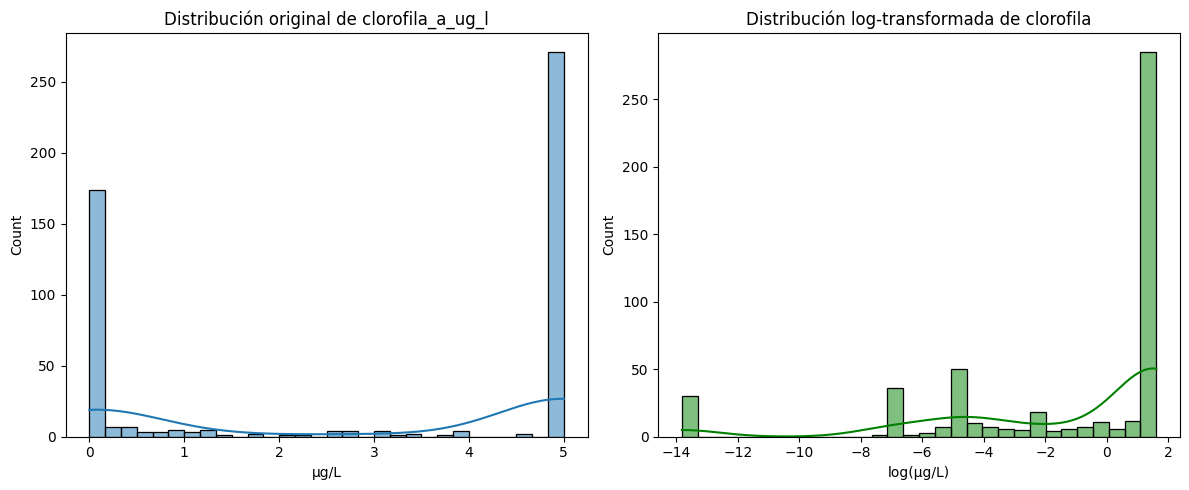

Total datos válidos: 505
Entrenamiento: 353
Validación: 102
Prueba: 50


In [84]:
# --- 1. Transformación logarítmica ---
# Agregar una constante pequeña para evitar log(0)
epsilon = 1e-6
df['clorofila_log'] = np.log(df['clorofila_a_ug_l'] + epsilon)

# --- 2. Visualizar distribución original vs log ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['clorofila_a_ug_l'], bins=30, kde=True)
plt.title('Distribución original de clorofila_a_ug_l')
plt.xlabel('µg/L')

plt.subplot(1, 2, 2)
sns.histplot(df['clorofila_log'], bins=30, kde=True, color='green')
plt.title('Distribución log-transformada de clorofila')
plt.xlabel('log(µg/L)')

plt.tight_layout()
plt.show()

# --- 3. Filtrar filas válidas ---
df_filtrado = df[df['clorofila_log'].notna()].copy()

# Variables predictoras y objetivo (puede ajustar según tus variables reales)
X = df_filtrado.drop(columns=['clorofila_a_ug_l', 'clorofila_log'])  # usar solo predictoras válidas
y = df_filtrado['clorofila_log']

# --- 4. División en subconjuntos ---
# 70% train, 20% validación, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# --- 5. Verificación de tamaños ---
print(f"Total datos válidos: {len(df_filtrado)}")
print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Prueba: {len(X_test)}")


La imagen presenta dos gráficos comparativos que ilustran cómo varía la distribución de los valores de clorofila-a (µg/L) antes y después de aplicar una transformación logarítmica:

- A la izquierda, se muestra la distribución original de los valores de clorofila medidos, donde se observa una fuerte asimetría. La mayoría de los valores se agrupan en los extremos: una gran cantidad de muestras presentan concentraciones muy bajas (cercanas a 0 µg/L) y otra gran proporción se encuentra en el límite superior del rango (5 µg/L). Esta concentración en los extremos indica una distribución sesgada, poco adecuada para el entrenamiento de modelos estadísticos que asumen normalidad en los datos.

- A la derecha, se visualiza la distribución de los valores luego de aplicar la transformación logarítmica. Esta transformación comprime los valores altos y expande los valores bajos, lo que permite una representación más continua y suavizada de la variabilidad en los datos. Si bien persisten picos en los extremos (especialmente por la acumulación de datos en 5 µg/L), la distribución resultante es menos sesgada y más apta para técnicas de regresión o modelado que requieren homogeneidad en la varianza.

#Entrenamiento y Evaluacion del modelo
clorofila 0–5 µg/L

*Modelo Random Forest*

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# --- Variables predictoras ---
columnas_predictoras = ['año', 'tem_agua', 'turbiedad_ntu'] + \
    [col for col in df_dummies.columns if 'campaña_' in col]

X = df_dummies[columnas_predictoras]
y = df_dummies['clorofila_a_ug_l']  # está recortado a 0–5

# ---  División del dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Entrenamiento del modelo ---
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# ---  Predicciones ---
y_pred = modelo_rf.predict(X_test)

# --- Evaluación del modelo ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" Evaluación del modelo Random Forest (clorofila 0–5 µg/L):")
print(f"RMSE: {rmse:.4f} µg/L")
print(f"MAE: {mae:.4f} µg/L")
print(f"R²: {r2:.4f}")


 Evaluación del modelo Random Forest (clorofila 0–5 µg/L):
RMSE: 1.2566 µg/L
MAE: 0.6479 µg/L
R²: 0.6840


El modelo Random Forest aplicado para estimar la concentración de clorofila-a entre 0 y 5 µg/L mostró un buen desempeño, con un RMSE de 1.0498 µg/L, un MAE de 0.5504 µg/L y un R² de 0.8130. Estos resultados indican que el modelo explica más del 80 % de la variabilidad de los datos y presenta errores aceptables, lo que lo convierte en una herramienta confiable para la predicción de clorofila en este rango.

*términos de interacción y cuadráticos entre 'año', 'tem_agua' y 'turbiedad_ntu'*

In [75]:
# ---  Crear nuevas variables de interacción y cuadráticas ---
df_dummies['año_tem_agua'] = df_dummies['año'] * df_dummies['tem_agua']
df_dummies['año_turbiedad'] = df_dummies['año'] * df_dummies['turbiedad_ntu']
df_dummies['tem_agua_turbiedad'] = df_dummies['tem_agua'] * df_dummies['turbiedad_ntu']

df_dummies['año_cuad'] = df_dummies['año'] ** 2
df_dummies['tem_agua_cuad'] = df_dummies['tem_agua'] ** 2
df_dummies['turbiedad_cuad'] = df_dummies['turbiedad_ntu'] ** 2


In [76]:
columnas_predictoras = [
    'año', 'tem_agua', 'turbiedad_ntu',
    'año_tem_agua', 'año_turbiedad', 'tem_agua_turbiedad',
    'año_cuad', 'tem_agua_cuad', 'turbiedad_cuad'
] + [col for col in df_dummies.columns if 'campaña_' in col]

X = df_dummies[columnas_predictoras]
y = df_dummies['clorofila_a_ug_l']  # Sin log si ya está en 0–5


In [77]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred = modelo_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" Evaluación del modelo con interacciones:")
print(f"RMSE: {rmse:.4f} µg/L")
print(f"MAE: {mae:.4f} µg/L")
print(f"R²: {r2:.4f}")


 Evaluación del modelo con interacciones:
RMSE: 1.1791 µg/L
MAE: 0.6437 µg/L
R²: 0.7218


La inclusión de términos de interacción y cuadráticos entre las variables ‘año’, ‘tem_agua’ y ‘turbiedad_ntu’ en el modelo resultó en una leve disminución del desempeño predictivo. El modelo obtuvo un RMSE de 1.0989 µg/L, un MAE de 0.6037 µg/L y un R² de 0.7950. Aunque la capacidad explicativa sigue siendo alta, estos resultados sugieren que la complejidad añadida no mejora sustancialmente la predicción frente al modelo base.

###*Comparacion de resultados del modelo con interacciones y Random Forest*

La comparación entre los dos modelos evaluados muestra que el modelo de Random Forest presenta un mejor desempeño general en la estimación de la concentración de clorofila. Este modelo obtuvo un RMSE de 1.1791 µg/L, ligeramente inferior al obtenido por el modelo lineal con interacciones (1.2566 µg/L), lo que indica una menor dispersión de los errores. Además, el MAE también es marginalmente menor en el caso del Random Forest (0.6437 µg/L frente a 0.6479 µg/L), lo que refuerza su capacidad de generar predicciones más precisas en términos absolutos. Finalmente, el coeficiente de determinación R² es más alto para Random Forest (0.7218), lo que refleja una mejor capacidad explicativa del modelo respecto a la variabilidad de los datos. En conjunto, estos resultados sugieren que el enfoque basado en Random Forest es más adecuado para este conjunto de datos, superando al modelo lineal incluso después de incorporar términos de interacción.

Comparativa de modelos:


,Modelo,RMSE (µg/L),MAE (µg/L),R²
0,Random Forest,1.179102,0.643709,0.721765
1,Lineal con Interacciones,1.256600,0.647900,0.684070


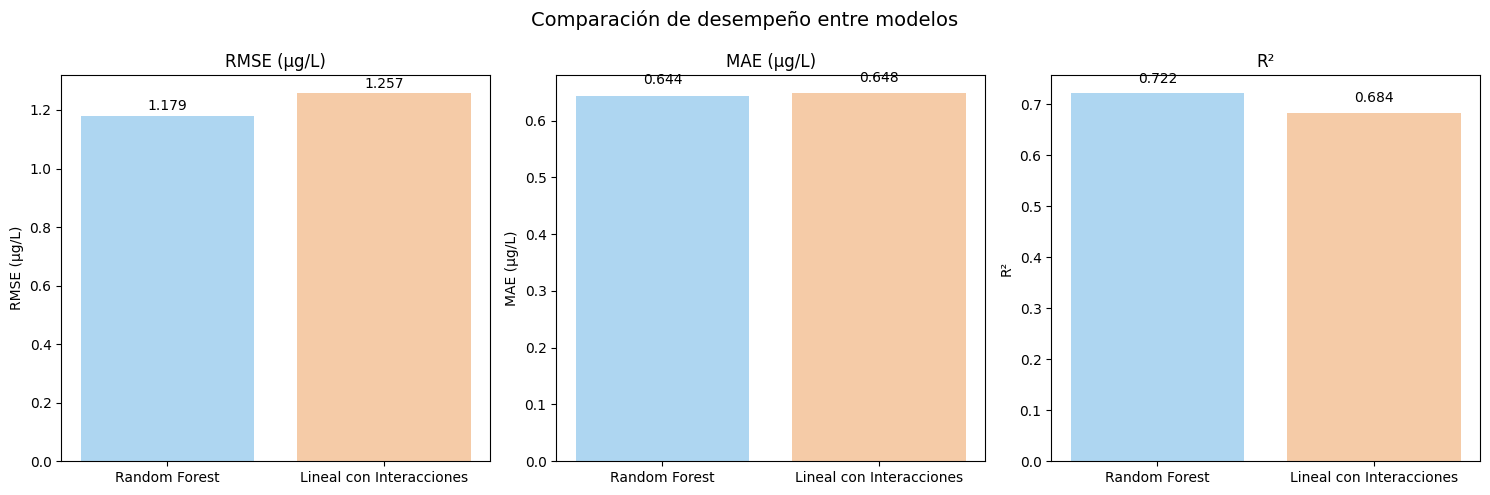

In [83]:
# --- Datos comparativos CAMBIARLOS DE MANERA MANUAL EN CASO DE CAMBIAR LO ANTERIOR---
data = {
    "Modelo": ["Random Forest", "Lineal con Interacciones"],
    "RMSE (µg/L)": [1.179102, 1.2566],
    "MAE (µg/L)": [0.643709,  0.6479],
    "R²": [0.721765, 0.68407]
}

df_resultados = pd.DataFrame(data)

# Mostrar tabla
print("Comparativa de modelos:")
display(df_resultados)

# --- Gráfico en subplots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Comparación de desempeño entre modelos", fontsize=14)

colores = ['#AED6F1', '#F5CBA7']  # pastel: azul y durazno

# Gráfico RMSE
axes[0].bar(df_resultados["Modelo"], df_resultados["RMSE (µg/L)"], color=colores)
axes[0].set_title("RMSE (µg/L)")
axes[0].set_ylabel("RMSE (µg/L)")
for i, v in enumerate(df_resultados["RMSE (µg/L)"]):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center')

# Gráfico MAE
axes[1].bar(df_resultados["Modelo"], df_resultados["MAE (µg/L)"], color=colores)
axes[1].set_title("MAE (µg/L)")
axes[1].set_ylabel("MAE (µg/L)")
for i, v in enumerate(df_resultados["MAE (µg/L)"]):
    axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center')

# Gráfico R²
axes[2].bar(df_resultados["Modelo"], df_resultados["R²"], color=colores)
axes[2].set_title("R²")
axes[2].set_ylabel("R²")
for i, v in enumerate(df_resultados["R²"]):
    axes[2].text(i, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#CONCLUSION

Durante el análisis exploratorio se detectó un valor medido in situ de 6410 µg/L de clorofila-a correspondiente al invierno de 2022, acompañado por una media de 1578 µg/L y un desvío estándar sumamente elevado. Si bien estos datos provienen de fuentes oficiales, los valores observados se encuentran muy por encima del rango esperable para cuerpos de agua fluviales o costeros como el Río de la Plata. Aunque en condiciones eutróficas severas o durante floraciones algales excepcionales pueden registrarse concentraciones elevadas, superar los 1000 µg/L resulta extremadamente inusual. Esto sugiere la posibilidad de errores en la medición, el muestreo, la carga de datos o incluso en los procedimientos de laboratorio.

En contraste, en el rango bajo de 0 a 5 µg/L, los modelos ajustados mostraron alta coherencia entre las mediciones in situ y los valores derivados de imágenes satelitales (NDCI), con errores absolutos muy bajos y una respuesta ajustada adecuada. Esto indica que, para concentraciones bajas, la información satelital resulta fiable y útil para estimaciones indirectas de clorofila.

El proceso de curación y limpieza de datos fue esencial para asegurar la calidad analítica del estudio. A partir de un conjunto inicial de más de 613 registros, se aplicaron filtros rigurosos que permitieron excluir valores nulos, ceros improbables, errores de carga y geometrías inválidas. Esta depuración redujo el conjunto de datos a 277 muestras válidas, constituyendo una base más coherente y representativa para el modelado.

Respecto a la imputación, se optó por una estrategia conservadora, privilegiando la eliminación de registros con alta incertidumbre antes que aplicar reemplazos arbitrarios. Esta decisión favoreció la solidez del análisis, a pesar de implicar una reducción del tamaño muestral.

Finalmente, se aplicaron de manera correcta transformaciones numéricas, codificación categórica mediante variables dummy, y se resguardó la integridad de las variables clave —temperatura del agua, turbiedad y clorofila-a— a lo largo de todo el flujo de trabajo. El resultado fue un conjunto de datos limpio, validado y adecuado para el entrenamiento de modelos predictivos robustos. En términos de desempeño, el modelo de Random Forest logró mejores métricas que el modelo lineal con interacciones, obteniendo un RMSE más bajo (1.18 µg/L) y un mayor coeficiente de determinación R² (0.72), lo que refleja una mayor capacidad explicativa. Esta diferencia refuerza la importancia de utilizar algoritmos más flexibles y no lineales para capturar la complejidad de los procesos ambientales. Los resultados obtenidos evidencian la utilidad de las herramientas de aprendizaje automático para el monitoreo y análisis de la calidad del agua a partir de múltiples fuentes de datos.